<a href="https://colab.research.google.com/github/pepedp/COVID-19/blob/master/Bolsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importación de las librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data_reader

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [6]:
#Importar el dataset de entrenamiento
fecha_final_train = "2020-06-30" #@param {type:"date"}
fecha_inicio_test = "2020-07-01" #@param {type:"date"}
stock_name = "GC=F" #@param {type:"string"}

#stock_name = "GC=F"
#fecha_final_train = '2020-06-30'
#fecha_inicio_test = '2020-06-01'

dataset_original  = data_reader.DataReader(stock_name, data_source="yahoo")
dataset_train_original = dataset_original[:fecha_final_train]
data_train  = dataset_train_original.iloc[:, 2:3].values #Salida un array 
x=dataset_train_original.index.values
dataset_train_original.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-06-25,1764.800049,1759.800049,1761.699951,1762.099976,207.0,1762.099976
2020-06-26,1772.500000,1764.699951,1766.000000,1772.500000,640.0,1772.500000
2020-06-28,1790.400024,1785.000000,1789.199951,1785.300049,500645.0,1785.300049
2020-06-29,1780.199951,1774.300049,1779.800049,1774.800049,584.0,1774.800049
2020-06-30,1793.199951,1774.400024,1777.300049,1793.000000,986.0,1793.000000


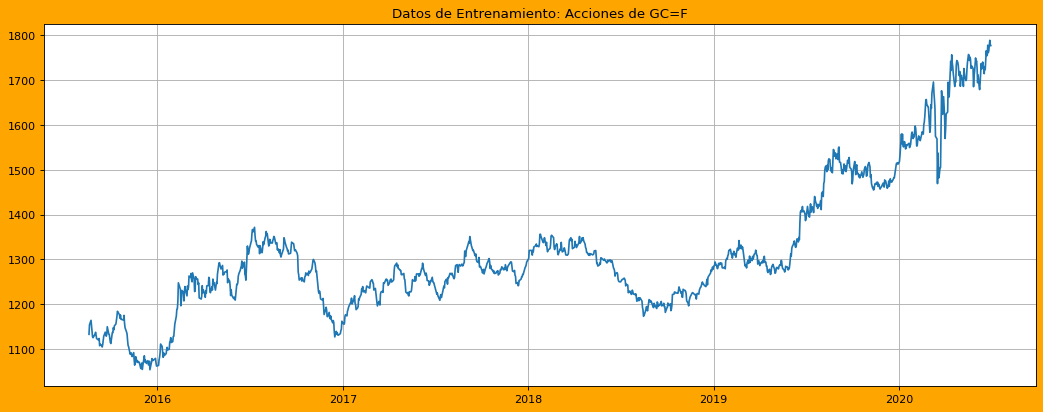

In [7]:
#GRAFICO DE DATOS ENTRENAMIENTO
x=dataset_train_original.index.values
plt.figure(figsize=(16, 6), dpi=80,facecolor="orange")
plt.grid()
plt.title("Datos de Entrenamiento: Acciones de {}".format(stock_name) )
plt.plot(x,data_train)

In [ ]:
#Escalado de características
from sklearn.preprocessing import MinMaxScaler
var_escalado = MinMaxScaler(feature_range = (0, 1)) #minimo sera 0 el maximo 1
data_train_escalado = var_escalado.fit_transform(data_train)

#GRAFICA
plt.figure(figsize=(16, 6), dpi=80,facecolor="orange")
plt.grid()
plt.title("Datos de Entrenamiento Escalados: Acciones de {}".format(stock_name) )
plt.plot(x,data_train_escalado)

In [9]:
#Crear una estructura de datos con 60 timesteps y 1 salida
#Definicion de variables 
x_train = []
y_train = []
valor_i = []
valores_previos = 60 #un trimestre 20 dias habiles al mes (Dias financieros) 

for i in range(valores_previos, len(x)):
    valor_i.append(i) #tamaño del array = (len(x)-60)
    x_train.append(data_train_escalado[i-valores_previos:i, 0])
    y_train.append(data_train_escalado[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
print("{} Valores previos para predecir (Memoria de la RNR LTSM): \n{}".format(
    valores_previos,
    x_train[0:2]) )
print("\ny = {}".format(y_train[0:2]) )

In [12]:
#opcional Agregar variables predictoras (Agregar dimensión)
#Agregar una dimensiones extra (profundidad) para pode agregar otras acciones que impacten a la predicción  
#Redimensionar x_train de una matriz (filas, columnas) a una matriz (filas, columnas, columna[0])
numero_filas = x_train.shape[0]
numero_colmunas = x_train.shape[1]
x_train_rnn = np.reshape(x_train, (numero_filas, numero_colmunas,1) )
print("Dimiension matriz: {} ".format(x_train_rnn.shape) )

Dimiension matriz: (1228, 60, 1) 


Contruccion de la RNN

In [33]:
#Construcción de la RNR
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

#Inicialización del modelo
modelo = Sequential()
neuronas = 250
droput=0.2
#Añadir la primera capa de LSTM y la regulariación por Dropout
modelo.add(LSTM(units = neuronas, return_sequences = True, input_shape = (x_train_rnn.shape[1], 1) ))
modelo.add(Dropout(droput)) #Usualmenete se usa 0.1 o 0.2 en una red LSTM

#Segunda capa de LSTM y la regulariación por Dropout
#Dropou para evitar overfitting
modelo.add(LSTM(units = neuronas, return_sequences = True ))
modelo.add(Dropout(droput))  

#Tercera capa de LSTM y la regulariación por Dropout
modelo.add(LSTM(units = neuronas, return_sequences = True ))
modelo.add(Dropout(droput))

#Cuarta capa de LSTM y la regulariación por Dropout
modelo.add(LSTM(units = neuronas))
modelo.add(Dropout(droput))


#Capa de salida
modelo.add(Dense(units = 1))

#Compilar la RNR
modelo.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
#NTRENAR LA RED NEURONAL
# Ajustar la RNR al conjunto de entrenamiento
entrenamientos = 100
print("Inicio proceso de entrenamiento")
modelo.fit(x_train_rnn, y_train, epochs = entrenamientos, batch_size = 32,verbose=True)
print("Fin proceso de entrenamiento")


In [28]:
#PREDICCIONES
#Obtener el valor de las acciones reales  de Enero de 2017
#dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
dataset_test = dataset_original[fecha_inicio_test:]
real_stock_price = dataset_test.iloc[:, 2:3].values

In [ ]:
dataset_test.head(50)

In [35]:
#Obtener la predicción de la acción con la RNR para Enero de 2017
dataset_total = pd.concat((dataset_train_original['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values #Limites inferior -60
inputs = inputs.reshape(-1,1)
inputs = var_escalado.transform(inputs)
X_test = []

for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1) )

predicted_stock_price = modelo.predict(X_test)
predicted_stock_price = var_escalado.inverse_transform(predicted_stock_price)

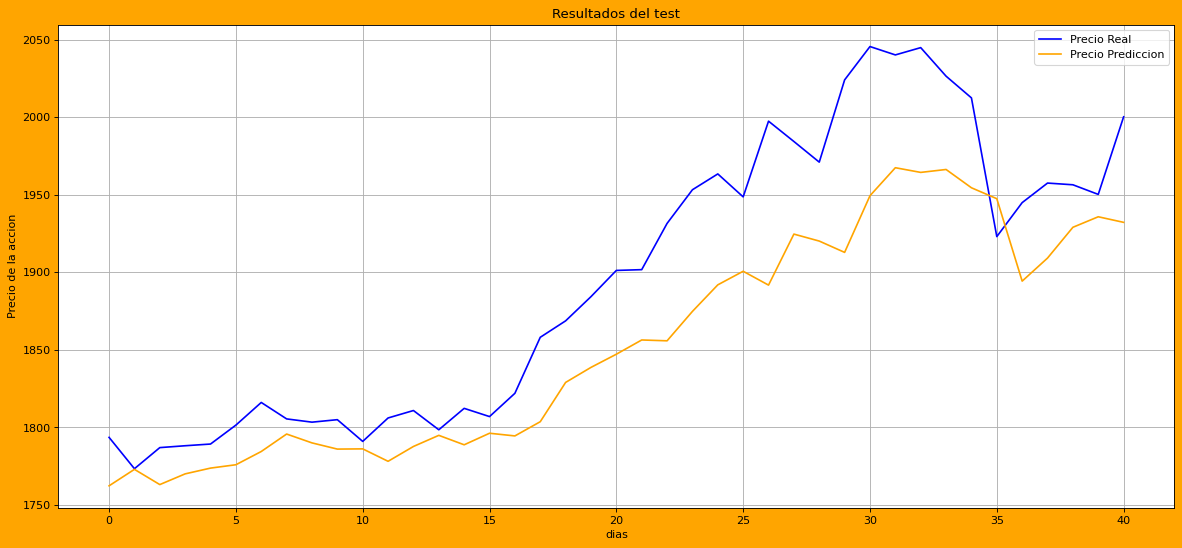

In [36]:
#Visualizar los Resultados
plt.figure(figsize=(18, 8), dpi=80,facecolor="orange")
plt.plot(real_stock_price, color = 'blue', label = 'Precio Real ')
plt.plot(predicted_stock_price, color = 'Orange', label = 'Precio Prediccion')

plt.grid()
plt.title("Resultados del test")
plt.xlabel("dias")
plt.ylabel("Precio de la accion")
plt.legend()
plt.show()

<bound method Model.evaluate of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f34de968550>>